
---
# Load needed libraries and functions

In [1]:

%run ../../load_magic/storage.py
%run ../../load_magic/environment.py
from scipy.stats import entropy
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import inspect
import matplotlib.pyplot as plt

# Use the following only if you are on a high definition device
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import numpy as np
import time
%pprint

notebook_path = get_notebook_path()
print(notebook_path)

s = Storage()
print(['s.{}'.format(fn) for fn in dir(s) if not fn.startswith('_')])
try:
    basic_quals_dict = s.load_object('basic_quals_dict')
except:
    basic_quals_dict = {}
dir()

Pretty printing has been turned OFF
C:\Users\dev\Documents\repositories\notebooks\Miscellaneous\ipynb\Job Hunting Classifier Scores.ipynb
['s.attempt_to_pickle', 's.data_csv_folder', 's.data_folder', 's.encoding_type', 's.load_csv', 's.load_dataframes', 's.load_object', 's.save_dataframes', 's.saves_csv_folder', 's.saves_folder', 's.saves_pickle_folder', 's.store_objects']
No pickle exists at C:\Users\dev\Documents\repositories\notebooks\Miscellaneous\saves\pickle\basic_quals_dict.pickle - attempting to load as csv.
No csv exists at C:\Users\dev\Documents\repositories\notebooks\Miscellaneous\saves\csv\basic_quals_dict.csv - attempting to download from URL.


['AdaBoostClassifier', 'BaggingClassifier', 'Config', 'CountVectorizer', 'ExtraTreesClassifier', 'GradientBoostingClassifier', 'In', 'LogisticRegression', 'Out', 'RandomForestClassifier', 'SVC', 'StackingClassifier', 'Storage', 'TfidfTransformer', 'VotingClassifier', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__nonzero__', '__package__', '__spec__', '_dh', '_i', '_i1', '_ih', '_ii', '_iii', '_oh', 'basic_quals_dict', 'csv', 'entropy', 'exit', 'get_classifier', 'get_data_structs_dataframe', 'get_datastructure_prediction', 'get_dir_tree', 'get_importances', 'get_input_sample', 'get_ipython', 'get_module_version', 'get_notebook_path', 'get_struct_name', 'inspect', 'ipykernel', 'json', 'jupyter_config_dir', 'notebook_path', 'notebookapp', 'np', 'os', 'pd', 'pickle', 'plt', 'preprocess_data', 'quit', 're', 's', 'set_matplotlib_formats', 'sys', 'time', 'urllib']

In [2]:

len(basic_quals_dict.keys())

0


---
# Needed extra functions

In [3]:

scanner_regex = re.compile(r'\b[1-9a-zA-Z][0-9a-zA-Z]*( *[#\+]{1,2}|\b)')
def regex_tokenizer(corpus):
    
    return [match.group() for match in re.finditer(scanner_regex, corpus)]


---
# Training

In [6]:

# Rebuild the datframe from the dictionary
rows_list = [{'qualification_str': qualification_str, 'is_fit': is_fit} for qualification_str, is_fit in basic_quals_dict.items()]
basic_quals_df = pd.DataFrame(rows_list, columns=['qualification_str', 'is_fit'])
s.store_objects(basic_quals_df=basic_quals_df)

# Re-transform the bag-of-words and tf-idf from the new manual scores
sents_list = basic_quals_df.qualification_str.tolist()
if len(sents_list):
    
    # Bag-of-words
    cv = CountVectorizer(lowercase=True, tokenizer=regex_tokenizer, token_pattern=r'\b[1-9a-zA-Z][0-9a-zA-Z]*[#\+]{0,2}', ngram_range=(1, 3))
    bow_matrix = cv.fit_transform(sents_list)
    s.store_objects(bq_cv_vocab=cv.vocabulary_)
    
    # Tf-idf, must get from BOW first
    tt = TfidfTransformer()
    tfidf_matrix = tt.fit_transform(bow_matrix)
    s.store_objects(bq_tt=tt)
    
    # Re-train the classifier
    X = tfidf_matrix.toarray()
    y = basic_quals_df.is_fit.to_numpy()
    fit_estimators_dict = s.load_object('fit_estimators_dict')
    #basic_quals_clf = RandomForestClassifier(n_estimators=997)
    #basic_quals_clf = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0, n_estimators=50, random_state=None)
    basic_quals_clf = fit_estimators_dict['LogisticRegression']
    basic_quals_clf.fit(X, y)
    s.store_objects(basic_quals_clf=basic_quals_clf)
    
    # Re-calibrate the inference engine
    bq_cv_vocab = s.load_object('bq_cv_vocab')
    bq_cv = CountVectorizer(vocabulary=bq_cv_vocab)
    bq_cv._validate_vocabulary()
    bq_tt = s.load_object('bq_tt')
    def predict_percent_fit(quals_list):
        y_predict_proba = np.array([])
        if len(quals_list):
            X_test = bq_tt.transform(bq_cv.transform(quals_list)).toarray()
            y_predict_proba = basic_quals_clf.predict_proba(X_test)

        return y_predict_proba
print('Retraining complete')

Pickling to C:\Users\dev\Documents\repositories\notebooks\Miscellaneous\saves\pickle\basic_quals_df.pickle
Retraining complete



---
# Rescore the quals dataframe

In [7]:

# Get the training data and models
X = tfidf_matrix.toarray()
y = basic_quals_df.is_fit.to_numpy()
estimators_list = [AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0, n_estimators=50, random_state=None),
                   BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False, max_features=1.0, max_samples=1.0,
                                     n_estimators=10, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False),
                   ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None, criterion='gini', max_depth=None,
                                        max_features='auto', max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0,
                                        min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False),
                   GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None, learning_rate=0.1, loss='deviance', max_depth=3,
                                              max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
                                              min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100,
                                              n_iter_no_change=None, presort='deprecated', random_state=None, subsample=1.0, tol=0.0001,
                                              validation_fraction=0.1, verbose=0, warm_start=False),
                   RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None, criterion='gini', max_depth=None, max_features='auto',
                                          max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0, min_impurity_split=None,
                                          min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                                          oob_score=False, random_state=None, verbose=0, warm_start=False),
                   LogisticRegression(**{'C': 7.5, 'class_weight': 'balanced', 'dual': True, 'fit_intercept': False, 'max_iter': 64,
                                         'penalty': 'l2', 'solver': 'liblinear', 'tol': 1e-09}),
                   SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
                       gamma='scale', kernel='rbf', max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001, verbose=False)]

# Fit the data and add the duration and fitted models to lists
fit_estimators_list = []
training_durations_list = []
for clf in estimators_list:
    start_time = time.time()
    fit_estimators_list.append(clf.fit(X, y))
    stop_time = time.time()
    training_durations_list.append(stop_time - start_time)
s.store_objects(estimators_list=fit_estimators_list, training_durations_list=training_durations_list)

NameError: name 'tfidf_matrix' is not defined

In [8]:

estimators_list = s.load_object('estimators_list')
inference_durations_list = []
for clf in estimators_list:
    clf_name = str(type(clf)).split('.')[-1].split("'")[0]
    basic_quals_df[clf_name] = np.nan
    start_time = time.time()
    for row_index, row_series in basic_quals_df.iterrows():
        qualification_str = row_series.qualification_str
        X_test = bq_tt.transform(bq_cv.transform([qualification_str])).toarray()
        y_predict_proba = clf.predict_proba(X_test)[0][1]
        basic_quals_df.loc[row_index, clf_name] = y_predict_proba
    stop_time = time.time()
    inference_durations_list.append(stop_time - start_time)
s.store_objects(basic_quals_df=basic_quals_df, inference_durations_list=inference_durations_list)

No pickle exists at C:\Users\dev\Documents\repositories\notebooks\Miscellaneous\saves\pickle\estimators_list.pickle - attempting to load as csv.
No csv exists at C:\Users\dev\Documents\repositories\notebooks\Miscellaneous\saves\csv\estimators_list.csv - attempting to download from URL.


ValueError: Invalid file path or buffer object type: <class 'NoneType'>

In [9]:

estimators_list = s.load_object('estimators_list')
clf = StackingClassifier(estimators=[(str(type(e)).split('.')[-1].split("'")[0], e) for e in estimators_list],
                         final_estimator=None, cv=None, stack_method='auto', n_jobs=None, passthrough=False, verbose=0)
clf_name = str(type(clf)).split('.')[-1].split("'")[0]
basic_quals_df = s.load_object('basic_quals_df')
basic_quals_df[clf_name] = np.nan
fit_estimators_list = estimators_list.copy()
bq_cv_vocab = s.load_object('bq_cv_vocab')
bq_cv = CountVectorizer(vocabulary=bq_cv_vocab)
bq_cv._validate_vocabulary()
bq_tt = s.load_object('bq_tt')
X = bq_tt.transform(bq_cv.transform(basic_quals_df.qualification_str.tolist())).toarray()
y = basic_quals_df.is_fit.to_numpy()
start_time = time.time()
fit_estimators_list.append(clf.fit(X, y))
stop_time = time.time()
training_durations_list = s.load_object('training_durations_list')
training_durations_list.append(stop_time - start_time)
s.store_objects(fit_estimators_list=fit_estimators_list, training_durations_list=training_durations_list)

# Re-score the quals dataframe
inference_durations_list = s.load_object('inference_durations_list')
start_time = time.time()
for row_index, row_series in basic_quals_df.iterrows():
    qualification_str = row_series.qualification_str
    X_test = bq_tt.transform(bq_cv.transform([qualification_str])).toarray()
    y_predict_proba = clf.predict_proba(X_test)[0][1]
    basic_quals_df.loc[row_index, clf_name] = y_predict_proba
stop_time = time.time()
inference_durations_list.append(stop_time - start_time)
s.store_objects(basic_quals_df=basic_quals_df, inference_durations_list=inference_durations_list)

Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\fit_estimators_list.pickle
Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\training_durations_list.pickle
Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\basic_quals_df.pickle
Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\inference_durations_list.pickle


In [10]:

clf = VotingClassifier(estimators=[(str(type(e)).split('.')[-1].split("'")[0], e) for e in estimators_list],
                       voting='soft', weights=None, n_jobs=None, flatten_transform=True)
clf_name = str(type(clf)).split('.')[-1].split("'")[0]
basic_quals_df[clf_name] = np.nan
fit_estimators_list = s.load_object('fit_estimators_list')
start_time = time.time()
fit_estimators_list.append(clf.fit(X, y))
stop_time = time.time()
training_durations_list = s.load_object('training_durations_list')
training_durations_list.append(stop_time - start_time)
s.store_objects(fit_estimators_list=fit_estimators_list, training_durations_list=training_durations_list)

# Re-score the quals dataframe
bq_cv_vocab = s.load_object('bq_cv_vocab')
bq_cv = CountVectorizer(vocabulary=bq_cv_vocab)
bq_cv._validate_vocabulary()
bq_tt = s.load_object('bq_tt')
inference_durations_list = s.load_object('inference_durations_list')
start_time = time.time()
for row_index, row_series in basic_quals_df.iterrows():
    qualification_str = row_series.qualification_str
    X_test = bq_tt.transform(bq_cv.transform([qualification_str])).toarray()
    y_predict_proba = clf.predict_proba(X_test)[0][1]
    basic_quals_df.loc[row_index, clf_name] = y_predict_proba
stop_time = time.time()
inference_durations_list.append(stop_time - start_time)
s.store_objects(basic_quals_df=basic_quals_df, inference_durations_list=inference_durations_list)

Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\fit_estimators_list.pickle
Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\training_durations_list.pickle
Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\basic_quals_df.pickle
Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\inference_durations_list.pickle


In [11]:

print(basic_quals_df.columns.tolist())
basic_quals_df.sample(5).T

['qualification_str', 'is_fit', 'AdaBoostClassifier', 'BaggingClassifier', 'ExtraTreesClassifier', 'GradientBoostingClassifier', 'RandomForestClassifier', 'LogisticRegression', 'SVC', 'StackingClassifier', 'VotingClassifier']


,1515,2788,3175,1388,5
qualification_str,"Experience with using R, Perl, Python, SAS, an...","Knowledge of SQL, including views, stored proc...",BA or BS degree or 2+ years of experience with...,"4+ years of experience with HTML, CSS, and Jav...",3 years of experience with developing software...
is_fit,1,1,0,1,1
AdaBoostClassifier,0.542486,0.522879,0.514952,0.680475,0.537742
BaggingClassifier,0.9,1,0.9,1,1
ExtraTreesClassifier,0.86,0.78,0.62,0.84,0.82
GradientBoostingClassifier,0.985335,0.912885,0.68758,0.900335,0.962283
RandomForestClassifier,0.79,0.82,0.76,0.74,0.75
LogisticRegression,0.938252,0.871707,0.702028,0.929243,0.953737
SVC,0.990763,0.947784,0.94697,0.980017,0.993239
StackingClassifier,0.956656,0.942173,0.566589,0.951504,0.950174


In [21]:

metrics_list = ['accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision_score',
                'balanced_accuracy_score', 'cohen_kappa_score', 'completeness_score', 'explained_variance_score',
                'f1_score', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard_score', 'mutual_info_score',
                'normalized_mutual_info_score', 'precision_score', 'r2_score', 'recall_score', 'roc_auc_score', 'v_measure_score']
exec('from sklearn.metrics import {}'.format(', '.join(metrics_list)))
fit_estimators_list = s.load_object('fit_estimators_list')
clf_name_list = [str(type(clf)).split('.')[-1].split("'")[0] for clf in fit_estimators_list]
basic_quals_df = s.load_object('basic_quals_df')
y_true = basic_quals_df.is_fit.tolist()
fit_match_series = (basic_quals_df.is_fit == 1)
yes_list = basic_quals_df[fit_match_series].is_fit.tolist()
no_list = basic_quals_df[~fit_match_series].is_fit.tolist()
columns_list = ['clf_name', 'training_duration', 'inference_duration', 'boundary_diff', 'clf_yes_entropy', 'relative_yes_entropy'] + metrics_list
rows_list = []
training_durations_list = s.load_object('training_durations_list')
inference_durations_list = s.load_object('inference_durations_list')
for column_name, training_duration, inference_duration in zip(clf_name_list, training_durations_list, inference_durations_list):
    yes_series = basic_quals_df[fit_match_series][column_name]
    upper_bound = yes_series.min()
    no_series = basic_quals_df[~fit_match_series][column_name]
    lower_bound = no_series.max()
    y_pred = []
    for p in basic_quals_df[column_name]:
        if p > 0.5:
            y_pred.append(1)
        else:
            y_pred.append(0)
    row_dict = {}
    row_dict['clf_name'] = column_name
    row_dict['training_duration'] = training_duration
    row_dict['inference_duration'] = inference_duration
    row_dict['boundary_diff'] = upper_bound-lower_bound
    row_dict['clf_yes_entropy'] = entropy(pk=yes_series.tolist())
    row_dict['relative_yes_entropy'] = entropy(pk=yes_list, qk=yes_series.tolist())
    for metric_str in metrics_list:
        try:
            row_dict[metric_str] = eval('{}(y_true, basic_quals_df[column_name].tolist())'.format(metric_str))
        except Exception as e1:
            try:
                row_dict[metric_str] = eval('{}(y_true, y_pred)'.format(metric_str))
            except Exception as e2:
                row_dict[metric_str] = np.nan
    rows_list.append(row_dict)
entropy_df = pd.DataFrame(rows_list, columns=columns_list).dropna(axis='columns', how='all')
entropy_df.set_index('clf_name', drop=True, inplace=True)
s.store_objects(entropy_df=entropy_df)

Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\entropy_df.pickle


In [22]:

description_dict = {name: fn.__doc__.strip().split('\n')[0] for name, fn in inspect.getmembers(sys.modules[__name__],
                                                                                               inspect.isfunction) if name in metrics_list}
entropy_df = s.load_object('entropy_df')
for name, cls in inspect.getmembers(sys.modules[__name__], inspect.isclass):
    if name in entropy_df.index:
        description_dict[name] = cls.__doc__.strip().split('\n')[0]
s.store_objects(metrics_list=metrics_list, description_dict=description_dict)

Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\metrics_list.pickle
Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\description_dict.pickle


In [23]:

print(entropy_df.columns.tolist())
metrics_list

['training_duration', 'inference_duration', 'boundary_diff', 'clf_yes_entropy', 'relative_yes_entropy', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision_score', 'balanced_accuracy_score', 'cohen_kappa_score', 'completeness_score', 'explained_variance_score', 'f1_score', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard_score', 'mutual_info_score', 'normalized_mutual_info_score', 'precision_score', 'r2_score', 'recall_score', 'roc_auc_score', 'v_measure_score']


['accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision_score', 'balanced_accuracy_score', 'cohen_kappa_score', 'completeness_score', 'explained_variance_score', 'f1_score', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard_score', 'mutual_info_score', 'normalized_mutual_info_score', 'precision_score', 'r2_score', 'recall_score', 'roc_auc_score', 'v_measure_score']

In [24]:

columns_list = ['training_duration', 'inference_duration', 'balanced_accuracy_score', 'r2_score']
entropy_df[columns_list].sort_values('balanced_accuracy_score', ascending=False)

,training_duration,inference_duration,balanced_accuracy_score,r2_score
clf_name,,,,
VotingClassifier,2170.178939,431.450733,0.990080,0.804408
StackingClassifier,9874.472116,428.601999,0.984123,0.916172
SVC,2020.160552,394.210950,0.857235,0.576415
LogisticRegression,0.602237,5.666944,0.842185,0.523171
ExtraTreesClassifier,102.148002,26.172915,0.812793,0.423201
RandomForestClassifier,38.459785,26.381432,0.682368,0.258416
BaggingClassifier,75.029012,13.678292,0.594085,-0.031229
GradientBoostingClassifier,512.273346,5.012151,0.583887,0.115597
AdaBoostClassifier,119.595983,34.276241,0.557272,0.022540


In [25]:

fit_estimators_list = s.load_object('fit_estimators_list')
fit_estimators_dict = {str(type(clf)).split('.')[-1].split("'")[0]: clf for clf in fit_estimators_list}
s.store_objects(fit_estimators_dict=fit_estimators_dict)

Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\fit_estimators_dict.pickle


cohen_kappa_score: Cohen's kappa: a statistic that measures inter-annotator agreement.
r2_score: R^2 (coefficient of determination) regression score function.
homogeneity_score: Homogeneity metric of a cluster labeling given a ground truth.


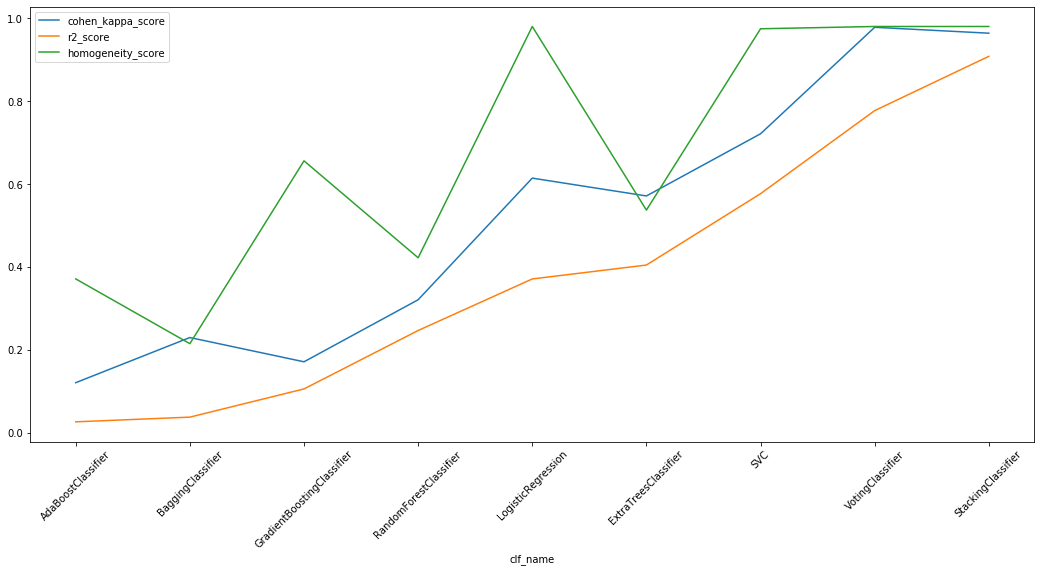

In [35]:

entropy_df = s.load_object('entropy_df')
metrics_list = s.load_object('metrics_list')
custom_metrics_list = ['boundary_diff', 'clf_yes_entropy', 'relative_yes_entropy']
columns_list = metrics_list + custom_metrics_list
columns_list = [cn for cn, s in sorted([(cn, entropy_df[cn].std()) for cn in columns_list], key=lambda x: x[1], reverse=True)][:3]
description_dict = s.load_object('description_dict')
for metric in columns_list:
    print('{}: {}'.format(metric, description_dict[metric]))
AxesSubplot_obj = entropy_df[columns_list].sort_values('r2_score', ascending=True).plot.line(rot=45, figsize=(18, 8))

balanced_accuracy_score: Compute the balanced accuracy
r2_score: R^2 (coefficient of determination) regression score function.


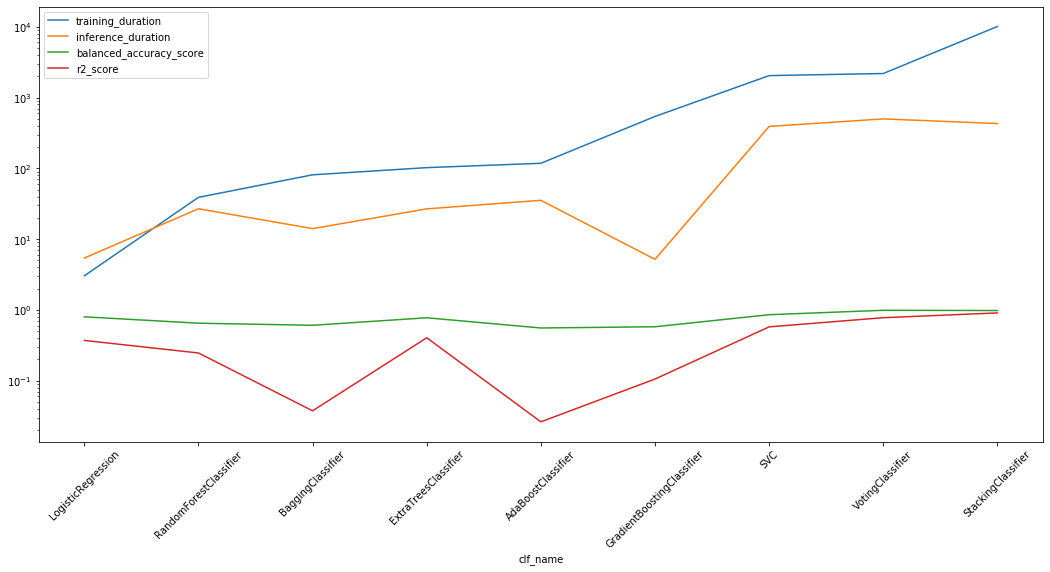

In [36]:

description_dict = s.load_object('description_dict')
columns_list = ['training_duration', 'inference_duration', 'balanced_accuracy_score', 'r2_score']
for metric in columns_list:
    if metric in description_dict:
        print('{}: {}'.format(metric, description_dict[metric]))
entropy_df = s.load_object('entropy_df')
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_yscale('log')
AxesSubplot_obj = entropy_df[columns_list].sort_values('training_duration', ascending=True).plot.line(rot=45, ax=ax)

accuracy_score: Accuracy classification score.
balanced_accuracy_score: Compute the balanced accuracy


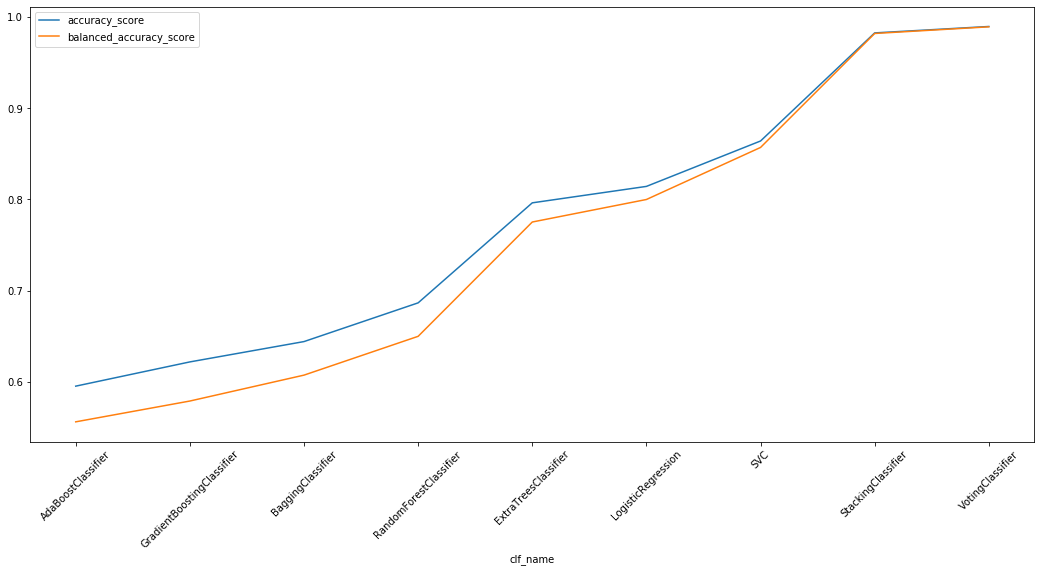

In [37]:

metrics_list = s.load_object('metrics_list')
columns_list = [cn for cn in metrics_list if 'accur' in cn.lower()]
for metric in columns_list:
    if metric in description_dict:
        print('{}: {}'.format(metric, description_dict[metric]))
AxesSubplot_obj = entropy_df[columns_list].sort_values('accuracy_score', ascending=True).plot.line(rot=45, figsize=(18, 8))

In [38]:

entropy_df[custom_metrics_list].sort_values('boundary_diff', ascending=False)

,boundary_diff,clf_yes_entropy,relative_yes_entropy
clf_name,,,
AdaBoostClassifier,-0.326660,7.501661,0.005136
VotingClassifier,-0.478308,7.500736,0.006958
RandomForestClassifier,-0.630000,7.496121,0.011526
GradientBoostingClassifier,-0.636707,7.487730,0.020336
ExtraTreesClassifier,-0.650000,7.492487,0.015704
LogisticRegression,-0.739466,7.485213,0.023357
StackingClassifier,-0.768875,7.500256,0.009413
BaggingClassifier,-0.800000,7.487856,0.021944
SVC,-0.965966,7.474945,0.044696


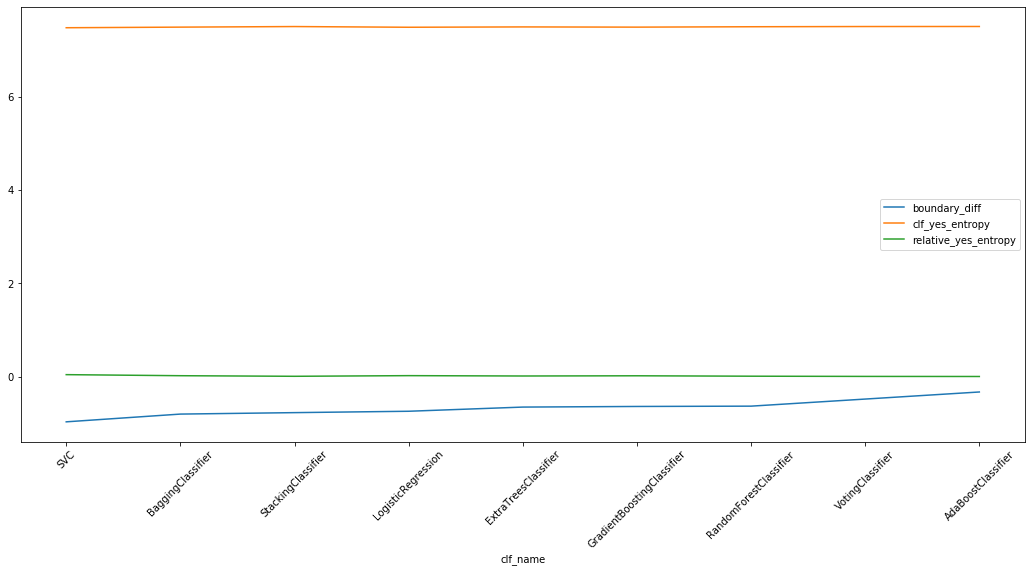

In [39]:

for metric in custom_metrics_list:
    if metric in description_dict:
        print('{}: {}'.format(metric, description_dict[metric]))
AxesSubplot_obj = entropy_df[custom_metrics_list].sort_values('boundary_diff', ascending=True).plot.line(rot=45, figsize=(18, 8))

average_precision_score: Compute average precision (AP) from prediction scores
precision_score: Compute the precision
recall_score: Compute the recall


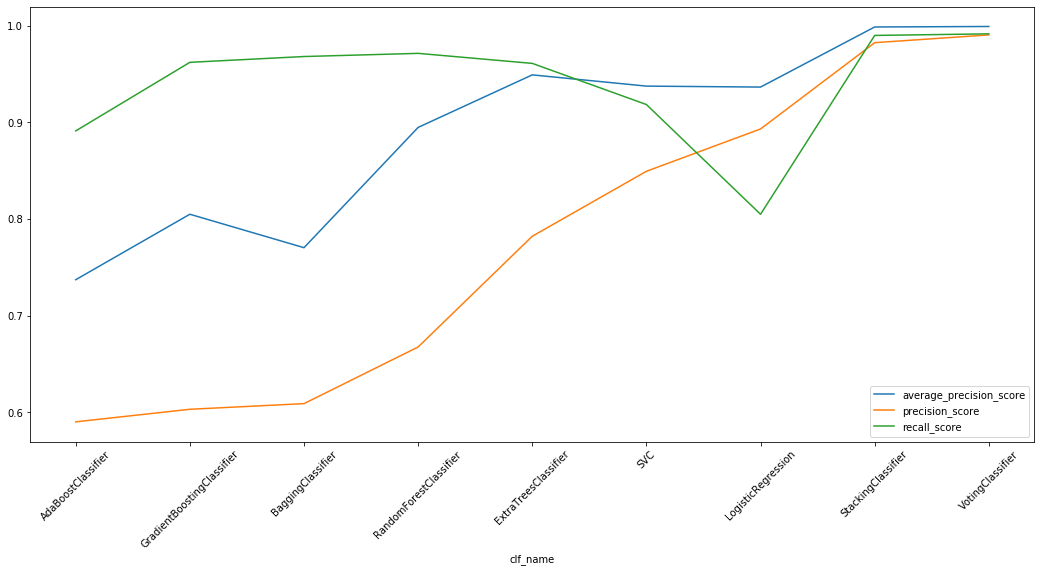

In [27]:

entropy_df = s.load_object('entropy_df')
columns_list = ['average_precision_score', 'precision_score', 'recall_score']
description_dict = s.load_object('description_dict')
for metric in columns_list:
    print('{}: {}'.format(metric, description_dict[metric]))
AxesSubplot_obj = entropy_df[columns_list].sort_values('precision_score', ascending=True).plot.line(rot=45, figsize=(18, 8))

In [28]:

extended_columns_list = ['training_duration', 'inference_duration'] + columns_list
entropy_df[extended_columns_list].sort_values('precision_score', ascending=True)

,training_duration,inference_duration,average_precision_score,precision_score,recall_score
clf_name,,,,,
AdaBoostClassifier,119.595983,34.276241,0.737098,0.589873,0.891257
GradientBoostingClassifier,512.273346,5.012151,0.804929,0.602876,0.962295
BaggingClassifier,75.029012,13.678292,0.770281,0.608726,0.968306
RandomForestClassifier,38.459785,26.381432,0.894894,0.667417,0.971585
ExtraTreesClassifier,102.148002,26.172915,0.949289,0.782125,0.961202
SVC,2020.160552,394.210950,0.937660,0.849419,0.918579
LogisticRegression,0.602237,5.666944,0.936665,0.893269,0.804918
StackingClassifier,9874.472116,428.601999,0.998922,0.982646,0.990164
VotingClassifier,2170.178939,431.450733,0.999427,0.990721,0.991803
